In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np


In [2]:
import matplotlib.pyplot as plt

we used 50 instances of the faulty data cuz len(normal data == 49)

In [58]:
# Load your data
normal = np.load('normal_data_scaled_freq_domain.npy')
horizontal_misalignment_data = np.load('horizontal_misalignment_data_data_scaled_freq_domain.npy')
imbalance_data = np.load('imbalance_data_scaled_freq_domain.npy')
vertical_misalignment_data = np.load('vertical_misalignment_data_scaled_freq_domain.npy')

In [51]:
vertical_misalignment_data.shape

(301, 9, 250)

In [52]:
imbalance_data.shape

(333, 9, 250)

In [53]:
horizontal_misalignment_data.shape

(197, 9, 250)

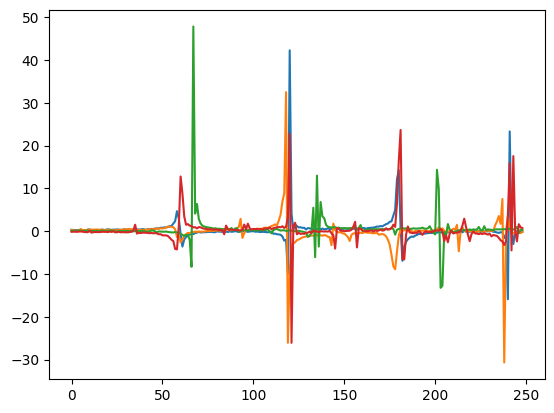

In [4]:
plt.plot(np.arange(len(normal[0][0][1:])),normal[0][0][1:])
plt.plot(np.arange(len(horizontal_misalignment_data[0][0][1:])),horizontal_misalignment_data[0][0][1:])
plt.plot(np.arange(len(imbalance_data[0][0][1:])),imbalance_data[0][0][1:])
plt.plot(np.arange(len(vertical_misalignment_data[0][0][1:])),vertical_misalignment_data[0][0][1:])
plt.show()

In [5]:
normal = np.delete(normal, 8, axis=1)
horizontal_misalignment_data = np.delete(horizontal_misalignment_data, 8, axis=1)
imbalance_data = np.delete(imbalance_data, 8, axis=1)
vertical_misalignment_data = np.delete(vertical_misalignment_data, 8, axis=1)

In [59]:
#add more normale data
def augment_data(original_data, target_instances):
    num_instances, num_sensors, num_data_points = original_data.shape
    augmented_data = np.zeros((target_instances, num_sensors, num_data_points))

    for i in range(target_instances):
        # Ensure the upper bound is greater than the lower bound
        start_point = np.random.randint(0, max(1, num_data_points - 500))
        augmented_data[i, :, :] = original_data[i % num_instances, :, start_point:start_point + 500]

    return augmented_data

# Assuming your original data is called 'original_data'
original_data_shape = (49, 8, 500)
target_instances = 400

normal = augment_data(normal, 500)
horizontal_misalignment_data = augment_data(horizontal_misalignment_data, target_instances)
imbalance_data = augment_data(imbalance_data, target_instances)
vertical_misalignment_data = augment_data(vertical_misalignment_data, target_instances)
print(normal.shape)  # Output: (100, 8, 500)


(500, 9, 250)


In [60]:
# Concatenate the datasets
data = np.concatenate([normal, horizontal_misalignment_data, imbalance_data,vertical_misalignment_data], axis=0)

#data = np.concatenate([normal, imbalance_data], axis=0)

# Create labels
y_normal = np.full(len(normal), "normal")
y_horizontal_misalignment = np.full(len(horizontal_misalignment_data), 'horizontal_misalignment')
y_imbalance = np.full(len(imbalance_data), 'imbalance')
y_vertical_misalignment = np.full(len(vertical_misalignment_data), 'vertical_misalignment')

labels = np.concatenate([y_normal,y_horizontal_misalignment, y_imbalance,y_vertical_misalignment])

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Convert data and labels to PyTorch tensors
data_tensor = torch.FloatTensor(data)
labels_tensor = torch.LongTensor(encoded_labels)

# Reshape data for LSTM (assuming it's a time series)
data_tensor = data_tensor.view(data_tensor.shape[0], 1, -1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_tensor, labels_tensor, test_size=0.2, random_state=42, stratify=labels_tensor)

# Define LSTM model
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Instantiate the model
input_size = X_train.size(2)
hidden_size = 100
num_classes = len(np.unique(encoded_labels))
model = SimpleLSTM(input_size, hidden_size, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Testing the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = accuracy_score(y_test.numpy(), predicted.numpy())
    print(f'Test Accuracy: {accuracy * 100:.2f}%')


Epoch [1/200], Loss: 1.4028
Epoch [2/200], Loss: 1.3715
Epoch [3/200], Loss: 1.3494
Epoch [4/200], Loss: 1.3300
Epoch [5/200], Loss: 1.3144
Epoch [6/200], Loss: 1.3000
Epoch [7/200], Loss: 1.2860
Epoch [8/200], Loss: 1.2730
Epoch [9/200], Loss: 1.2611
Epoch [10/200], Loss: 1.2490
Epoch [11/200], Loss: 1.2369
Epoch [12/200], Loss: 1.2249
Epoch [13/200], Loss: 1.2129
Epoch [14/200], Loss: 1.2008
Epoch [15/200], Loss: 1.1879
Epoch [16/200], Loss: 1.1749
Epoch [17/200], Loss: 1.1618
Epoch [18/200], Loss: 1.1486
Epoch [19/200], Loss: 1.1340
Epoch [20/200], Loss: 1.1190
Epoch [21/200], Loss: 1.1041
Epoch [22/200], Loss: 1.0886
Epoch [23/200], Loss: 1.0729
Epoch [24/200], Loss: 1.0576
Epoch [25/200], Loss: 1.0418
Epoch [26/200], Loss: 1.0261
Epoch [27/200], Loss: 1.0099
Epoch [28/200], Loss: 0.9933
Epoch [29/200], Loss: 0.9763
Epoch [30/200], Loss: 0.9585
Epoch [31/200], Loss: 0.9411
Epoch [32/200], Loss: 0.9241
Epoch [33/200], Loss: 0.9069
Epoch [34/200], Loss: 0.8891
Epoch [35/200], Loss: 0

In [64]:
# Define a more complex LSTM model
class AdvancedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.02):
        super(AdvancedLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(self.relu(out))
        return out

# Instantiate the model
input_size = X_train.size(2)
hidden_size = 128
num_layers = 2
num_classes = len(np.unique(encoded_labels))
model = AdvancedLSTM(input_size, hidden_size, num_layers, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Testing the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = accuracy_score(y_test.numpy(), predicted.numpy())
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

Epoch [1/50], Loss: 1.3844
Epoch [2/50], Loss: 1.3800
Epoch [3/50], Loss: 1.3760
Epoch [4/50], Loss: 1.3723
Epoch [5/50], Loss: 1.3684
Epoch [6/50], Loss: 1.3639
Epoch [7/50], Loss: 1.3593
Epoch [8/50], Loss: 1.3539
Epoch [9/50], Loss: 1.3478
Epoch [10/50], Loss: 1.3410
Epoch [11/50], Loss: 1.3329
Epoch [12/50], Loss: 1.3242
Epoch [13/50], Loss: 1.3144
Epoch [14/50], Loss: 1.3034
Epoch [15/50], Loss: 1.2910
Epoch [16/50], Loss: 1.2771
Epoch [17/50], Loss: 1.2622
Epoch [18/50], Loss: 1.2459
Epoch [19/50], Loss: 1.2283
Epoch [20/50], Loss: 1.2090
Epoch [21/50], Loss: 1.1881
Epoch [22/50], Loss: 1.1658
Epoch [23/50], Loss: 1.1423
Epoch [24/50], Loss: 1.1169
Epoch [25/50], Loss: 1.0908
Epoch [26/50], Loss: 1.0632
Epoch [27/50], Loss: 1.0346
Epoch [28/50], Loss: 1.0055
Epoch [29/50], Loss: 0.9754
Epoch [30/50], Loss: 0.9449
Epoch [31/50], Loss: 0.9133
Epoch [32/50], Loss: 0.8820
Epoch [33/50], Loss: 0.8498
Epoch [34/50], Loss: 0.8184
Epoch [35/50], Loss: 0.7867
Epoch [36/50], Loss: 0.7556
E

In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Load the dataset
# Assuming 'X' contains the features and 'y' contains the labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the labels to categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Build the deep learning model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
